In this notebook, we primarily utilized Sam Weinberg's Notebook (https://www.kaggle.com/samweinberg/field-control-visualization), wherein the relevant parts of our code drew from the following resources:

Rob Mulla's Notebook - "Plotting Player Position" (https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position)
Andika Rachman's Notebook - "Animating Player Movement" (https://www.kaggle.com/ar2017/nfl-big-data-bowl-2021-animating-players-movement)


**Introduction**

It seems for the past 5 months, the Mina Kimes Podcast (ft. Lenny), GMFB, or NFL Live have had something to say about who won the the “Jamal Adams Trade.” The argument over Adams’ worth is reenergized each week when one of two things typically happens on a Sunday: 
(a) Jamal Adams has an interception, 2 forced fumbles, and a sack on a 3rd and long that swings the outcome of the game; or 
(b) Adams was beat in coverage by Tyler Higbee or some other TE with half his athleticism at a crucial time because Adams was guessing run, abandoned his zone, got caught looking in the backfield, etc. 

The frequency of the Adams debate is an instructive entry in to the purpose of this project: the quantification and evaluation of the attacking safety. Within this project we will describe how we identify an attacking safety, which teams use their safeties to attack most frequently, which individual safeties attack most frequently, and which offenses receives the most attacks from opposition safeties. Furthermore, we will use outcome variables such as EPA, incompletions, and "big plays"  to determine the efficacy of attacking safeties.


Out ultimate goal is to then able to weigh the cost vs. benefit of a player like Adams. Is he worth the draft capital the Seahawks gave up for him? Or is his play style so detrimental that no amount of “big moment” plays can make up for the times he exposes his defense because he’s just “following his gut out there.” 

Identifying an Attacking Safety

We differentiate between a safety “attack” and a safety “blitz” for a number of reasons. While we absolutely want to incorporate safety blitzes into our analysis of pass defense, safety blitzes drawn up by the defensive coordinator make up just a portion of what make attacking safeties worth exploring. In identifying when a safety “attacks,” we attempt to account forthe following:
	(i) A called safety blitz
	(ii) An uncalled safety blitz
	(iii) A safety following his instincts and attacking the line of scrimmage at the snap
	(iv) A safety misreading the play (biting on play-action) and continuing his run toward the line of scrimmage. 
    
Below we detail our methodology on generating the "Attacking Safety" Metric    

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from pathlib import Path
from textwrap import wrap

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ipywidgets import interact, fixed

%matplotlib inline
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

import dateutil
from math import radians
from IPython.display import Video

In [ ]:
def create_football_field(fig,
                          ax,
                          linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          fifty_is_los=False):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='gray', facecolor='white', zorder=0)

    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='grey')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='grey',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='grey',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='grey')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='grey', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='grey')
        ax.plot([x, x], [53.0, 52.5], color='grey')
        ax.plot([x, x], [22.91, 23.57], color='grey')
        ax.plot([x, x], [29.73, 30.39], color='grey')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='blue')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
    return fig, ax


# Create animation of play


def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
def animate_player_movement(weekData, playData, playId, gameId):
#     weekData = pd.read_csv(input_dir + 'week' + str(weekNumber) + '.csv')
#     playData = pd.read_csv(input_dir + '/plays.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    figsize=(12, 6.33)
    fig, ax = plt.subplots(1, figsize=figsize)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        create_football_field(fig,ax,highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)

        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white'))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Home players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white'))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Away players' location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

In [ ]:
# defining relevant data directories and file names for relevant data import
data_dir = Path('/kaggle/input/nfl-big-data-bowl-2021')
plays_fname = Path('plays.csv')
players_fname = Path('players.csv')
games_fname = Path('games.csv')

# reading the data into separate dataframes for processing and output
games_df= pd.read_csv(data_dir.joinpath(games_fname))
plays_df = pd.read_csv(data_dir.joinpath(plays_fname))
players_df = pd.read_csv(data_dir.joinpath(players_fname))

# Because the data processing performed for this submission was ultimately exported to Stata for further statistical analysis, 
# we ultimately wanted to append the plays dataset with a number of new parameters developed for our "attacking" analysis. 
# In particular, 
plays_df['isSafetyAttack'] = [0] * np.size(plays_df.gameId)
plays_df['attackingSafety1'] = [None] * np.size(plays_df.gameId)
plays_df['attackingSafety2'] = [None] * np.size(plays_df.gameId)
plays_df['attackingSafety3'] = [None] * np.size(plays_df.gameId)
plays_df['attackingSafety4'] = [None] * np.size(plays_df.gameId)
plays_df['attackingSafety5'] = [None] * np.size(plays_df.gameId)
plays_df['safetyOnField1'] = [None] * np.size(plays_df.gameId)
plays_df['safetyOnField2'] = [None] * np.size(plays_df.gameId)
plays_df['safetyOnField3'] = [None] * np.size(plays_df.gameId)
plays_df['safetyOnField4'] = [None] * np.size(plays_df.gameId)
plays_df['safetyOnField5'] = [None] * np.size(plays_df.gameId)
plays_df['defendingTeam'] = [None] * np.size(plays_df.gameId)

# The data processor is generic to which defensive positions are classified as attacking on a given play. This particular analysis
# is analyzing any safety on the field for a given play.
positions = ['FS', 'SS']
# The attack threshold metric filters the specified positions to classify an "attacking" action during a play. 
# The metric is defined as the percentage of frames between snap and throw (or any other event that could cause the defender 
# to stop attacking the line of scrimmage) in which the defender is moving towards the line of scrimmage. 
# For this particular analysis, we set the attack threshold to be 85% - thus, if a defender's x-position is moving towards the LOS for 
# more than 85% of the frames within the relevant window, he would be classified as "attacking."
attack_threshold = 0.85
end_window_events = ['pass_forward', 'qb_sack', 'pass_shovel', 'qb_strip_sack', 'run']

# Specify which weeks we want to analyze.
# For our analysis, we wanted to consider the entire dataset, so we're looping over every play of every game in each week to populate our new columns
weeks_to_analyze = [6, 15, 17] #range(1, 18)

for week in weeks_to_analyze:
    week_fname = Path('week%i.csv' % week)
    week_df = pd.read_csv(data_dir.joinpath(week_fname))
    for game in np.unique(week_df.gameId):

        team_plays = plays_df[plays_df.gameId == game]
        team_plays_details = week_df[week_df.gameId == game]
        unique_plays = np.unique(team_plays_details.playId)

        for play_id in unique_plays:
            plays_idx = np.intersect1d(np.where(plays_df.playId == play_id), np.where(plays_df.gameId == game))[0]
            play = team_plays_details[team_plays_details.playId == play_id]
            players = play.nflId.unique()
            play_direction = play.playDirection.values[0]
            
            safeties = [player for player in players if players_df.position[(player == players_df.nflId)].values in positions]

            plays_df.defendingTeam.iat[plays_idx] = np.setdiff1d(np.array([games_df[games_df.gameId == game]['homeTeamAbbr'].values[0], games_df[games_df.gameId == game]['visitorTeamAbbr'].values[0]]), np.array([plays_df.possessionTeam.values[plays_idx]]))[0]
            if not safeties: # if there are no safeties on the field, then skip the play
                continue
            else:
                for iSafety, player in enumerate(safeties):
                    plays_df['safetyOnField%i' % (iSafety+1)].iat[plays_idx] = players_df.displayName[players_df.nflId == player].values[0]
            
            start_window = play.frameId.values[np.where(play.event == 'ball_snap')][0]
            # get each play event, so that we can loop over them to determine which event triggers an end to our window
            play_events = np.unique(play.event.values[play.event != 'None'])
            try: # hacky try/catch in case a play doesn't include an end window event defined above
                end_window_event = [event for event in play_events if event in end_window_events][0]
                end_window = play.frameId.values[np.where(play.event == end_window_event)][0]
            except:
                continue
            # get each safety's trajectory during the window of interest
            relevant_trajectories = [play.x.values[np.where(play.nflId == player)][start_window+1:end_window+1] for player in safeties]
            # calculate our attack metric
            if play_direction == 'left':
                attack_criteria = np.array([sum(np.diff(traj) > 0) / (np.size(traj)) for traj in relevant_trajectories if np.size(traj)>0])
            else:
                attack_criteria = np.array([sum(np.diff(traj) < 0) / (np.size(traj)) for traj in relevant_trajectories if np.size(traj)>0])
            # see if any safety's attack metric is above the specified threshold value and, if so, append to the dataframe
            if any(attack_criteria >= attack_threshold):
                plays_df['isSafetyAttack'].iat[plays_idx] = 1
                iSafety = 1
                for player, bc in zip(safeties, attack_criteria):
                    if bc >= attack_threshold:
                        plays_df['attackingSafety%i' % iSafety].iat[plays_idx] = players_df.displayName.values[np.where(players_df.nflId == player)][0]
                        iSafety += 1

Below we animate a handful of notable plays that we have tagged as downs in which a safety attacks, showing the high end and low end of potential outcomes.  

![](https://cdn.vox-cdn.com/uploads/chorus_asset/file/13658403/Mosley.gif)

![](https://i2.wp.com/media.giphy.com/media/d7MmfauxGRclIXgMF2/giphy.gif?resize=353%2C161&ssl=1)

![](https://thumbs.gfycat.com/BlushingEuphoricAiredale-max-1mb.gif)

In [ ]:
for play in [1, 2, 3]:
    if play==1:
        play_name = 'jamal_adams_sack'
        week = 15
        game_id = 2018121500
        play_id = 3146
    elif play==2:
        play_name = 'mosley_int'
        week = 17
        game_id = 2018123000
        play_id = 4376
    elif play==3:
        play_name = 'bengals_blitz'
        week = 6
        game_id = 2018101401
        play_id = 4061

    week_fname = Path('week%i.csv' % week)
    week_df = pd.read_csv(data_dir.joinpath(week_fname))

    # Animate our example play
    anim = animate_player_movement(week_df, plays_df, play_id, game_id)
    writer = FFMpegWriter(fps=10)
    anim.save('%s.mp4' % play_name, writer=writer)
    Video('%s.mp4' % play_name, embed=True)
    plays_df[['possessionTeam', 'defendingTeam', 'isSafetyAttack','attackingSafety1','attackingSafety2','passResult', 'playResult', 'epa']].loc[np.where((plays_df.gameId == game_id) & (plays_df.playId == play_id))].head()


**Which teams use their safeties to attack?** 
Of the 19,239 pass plays that occurred in 2018, a safety attacked the line of scrimmage on 17.73% of those downs.  

Team Attack Rate.jpg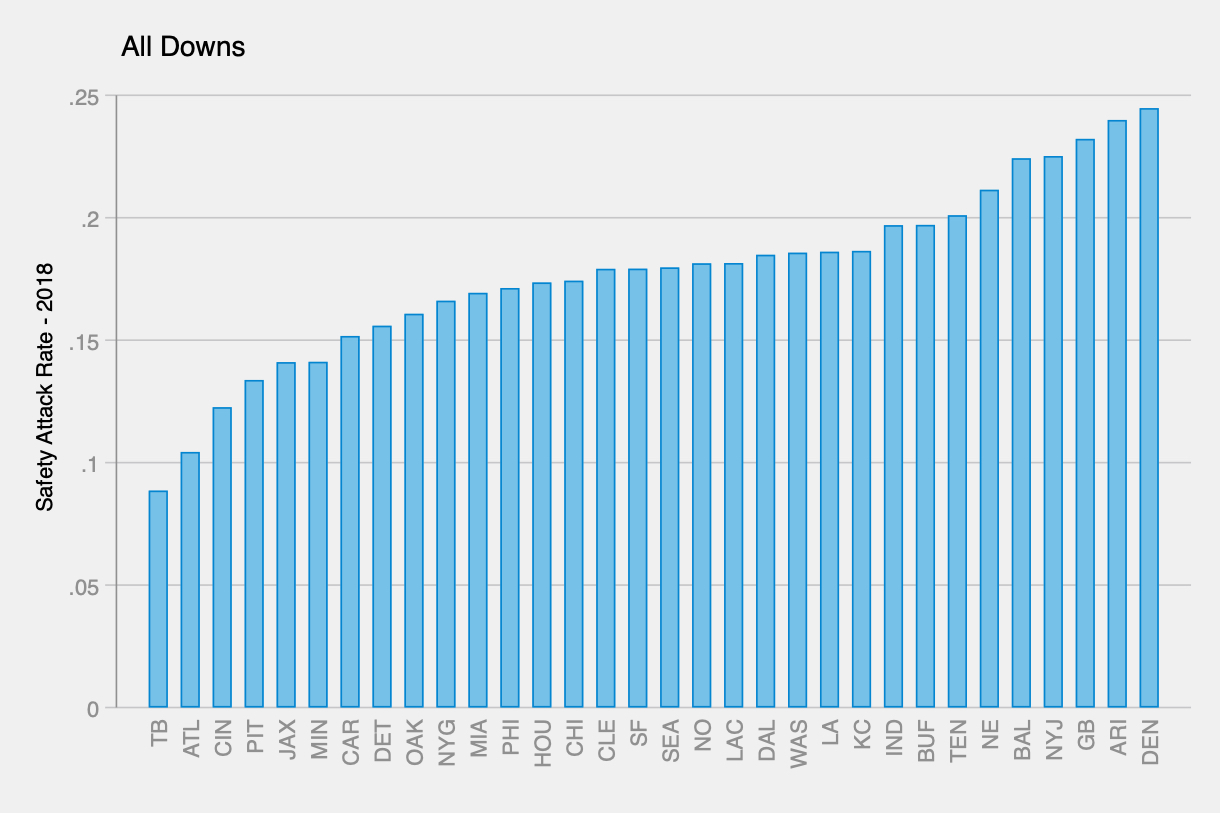

The distribution of safety attack rate across a variety of high leverage situations is instructive in assessing how teams value an attacking safety and the expected risk vs. reward in a given situation. The Rams ("LA"), for example, are less than 10% likely to allow their safeties to attack in the 4th quarter of a one score game, clearly an attempt to mitigate the risk of getting beat over the top. The Ravens ("BAL"), on the other hand, are allowing their safeties to attack on nearly 40% of downs in similar situation, clearly attempting to force the action and create big plays. That same Rams team, however, attacks with their safeties at the third highest rate in the league when defending in the red zone! Given the constrained field of play in the red zone, it appears the Rams are less concerned about getting beat over the top and are willing to let their safeties force the action. 

team high leverage.jpg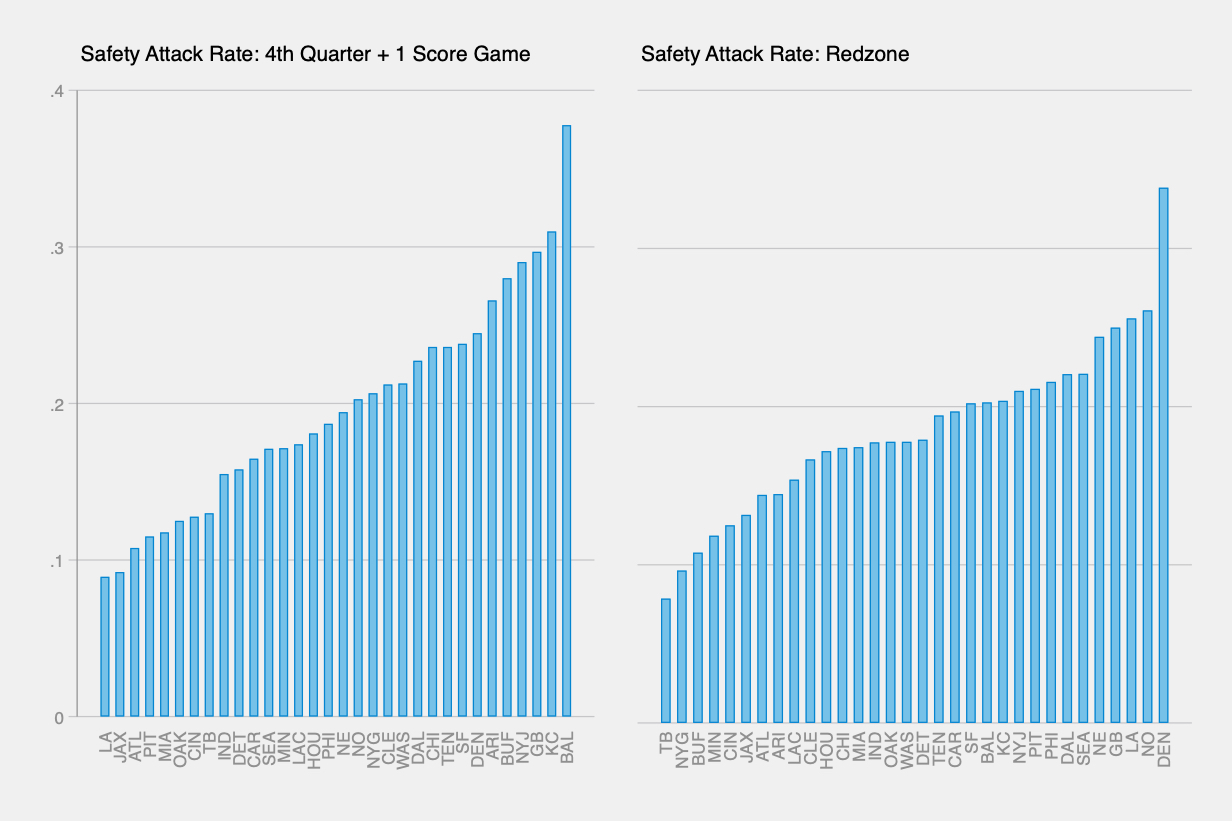

**Evaluation of Effectiveness**

Given that Jamal Adams is our entry into the project, we use Adams as a proxy for evaluating individual safety effctiveness on the attack. In 2018, Adams attacked most the any other safety in the league, 122 times in 632 downs (19.3%), while accounting for 85% of the Jets' total safety attacks. To explore the effectiveness of safety attacks from a team perspective, we find the Baltimore Ravens to be most instructive. Not only were the Ravens one of the top 2 defenses in the league in 2018, but we found that the employ the safety attack using individual safeties interchangably (Weddle: 64 Attacks, Jefferson: 70 Attacks, Clark: 22 Attacks). 

**Effectiveness of Safety Attacks on Completions & EPA**

adams v bal.jpg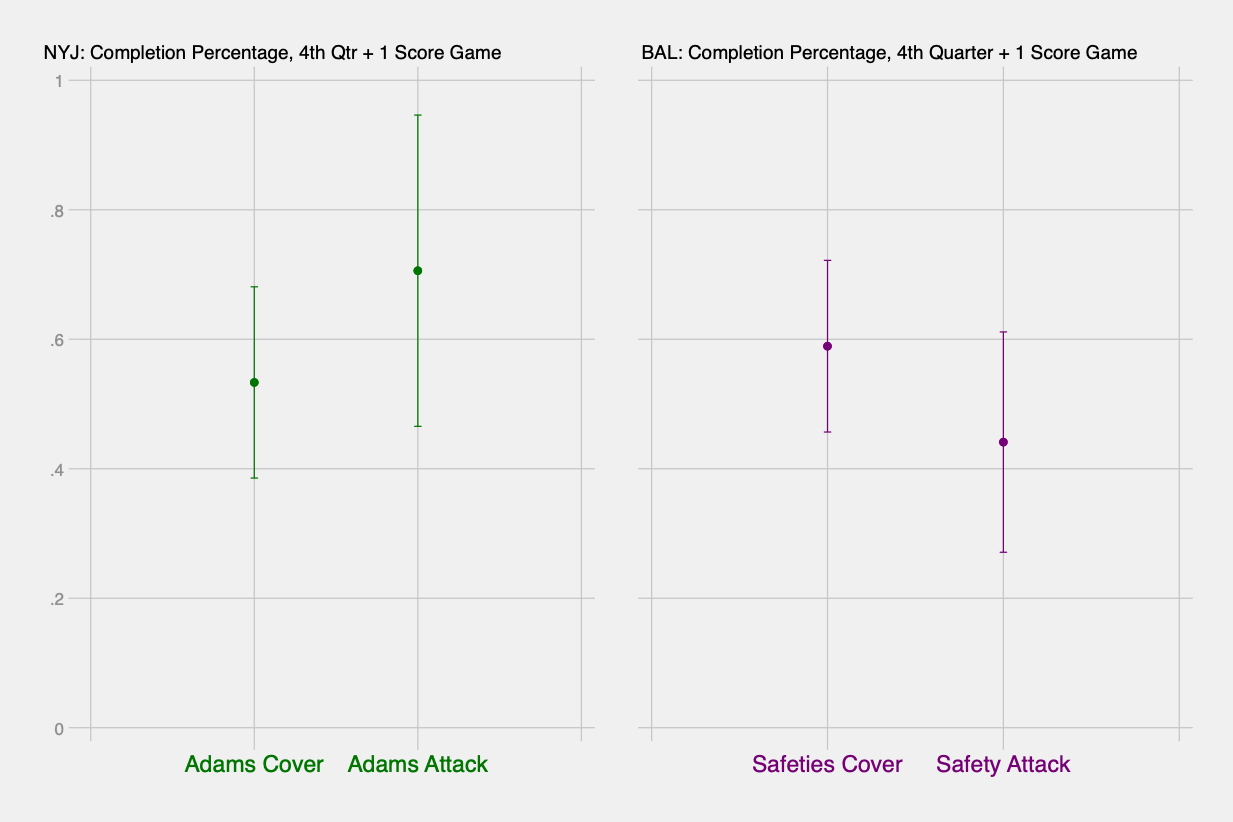

Above we demonstrate the effect safeties have on completion percentage in a high leverage situation (4th quarter of a one score game), showing both Jamal Adams himself and the Ravens defence overall. When Adams attacks, mean completion percentage increases. Assigning logic to this relationship, we can say that the reason for this is that QBs are getting the ball out faster. The graph below shows that this isn't necessarily a bad thing, as we find elsewhere that both epa and yards per completion decrease when a pass is completed during a safety attack. 

Looking at the Ravens, we find that the attacking safety decreases the likelihood of a completed pass in high levarage situations. 

kdensity.jpg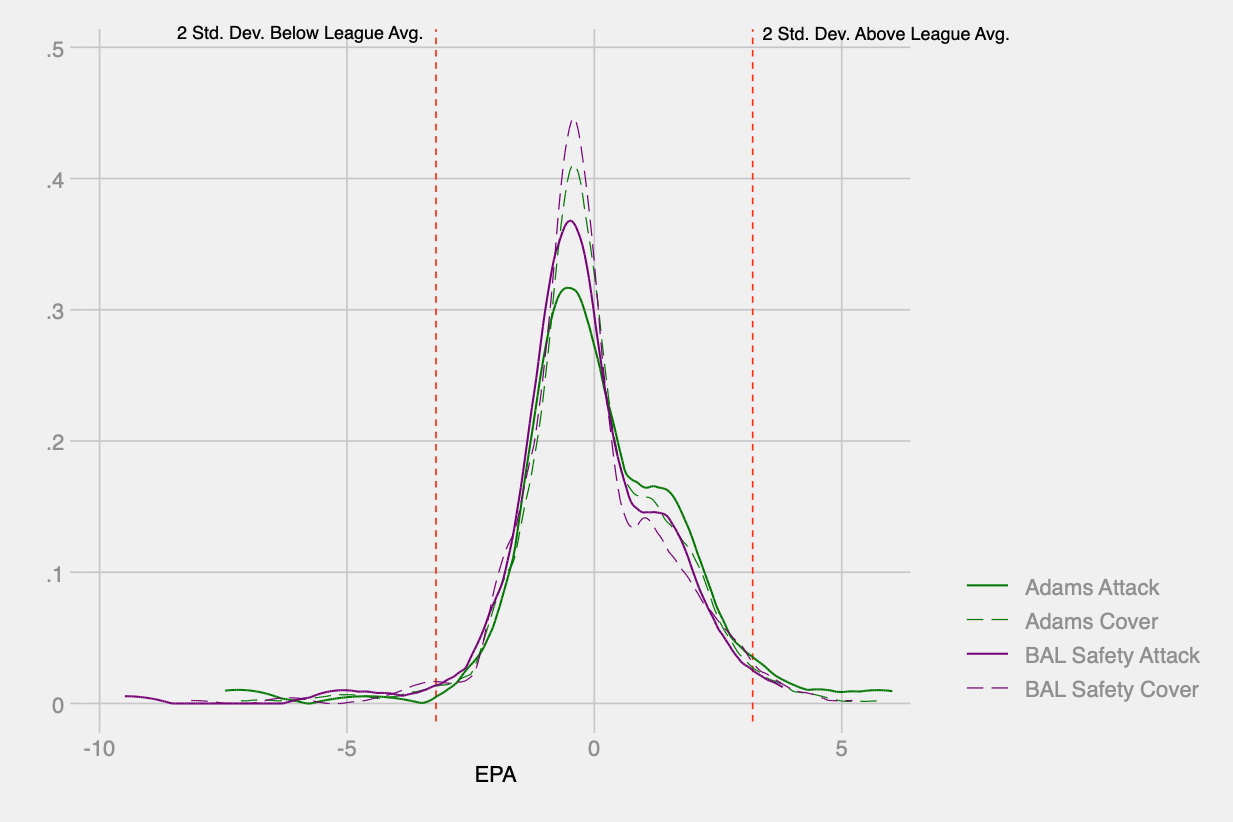

Both Adams and the Ravens have a similar distribution of EPA, clustering somewhat below the league mean of 0.02. Comparing Adams playing coverage to Adams attacking, the distributions tell us that, on average, not much difference can be found on the majority of plays. Notable, however, are the tails of the distribution in which the Adams attach exposes the Jets to giving up greater plays (greater density in larger EPA segments) while also increasing the chances for a "momentum" play, (greater density in larger negative EPA segments). 

The Ravens distribution shows that the team has mitigated much of the perceived risk in how using safeties to attack. When attacking, the Ravens defense does not allow a play with an EPA greater than 3.8, while averaging an EPA of -0.17 and achieving a maximum score of -9.48. This indicates to us that the Ravens' strategic utilization of the safety attack, both in personnel and game situation, has allowed them to capitalize on the benefits while mitigating the risk. 

**Employing the Safety Attack**

This then begs the question: against which teams are safety attacks most successful? The answer didn't particularly surprise us, as many of the most successful 2018 teams performed well against the safety attack, while many of the least successful teams did not. 

Team EPA Offense Attack.jpg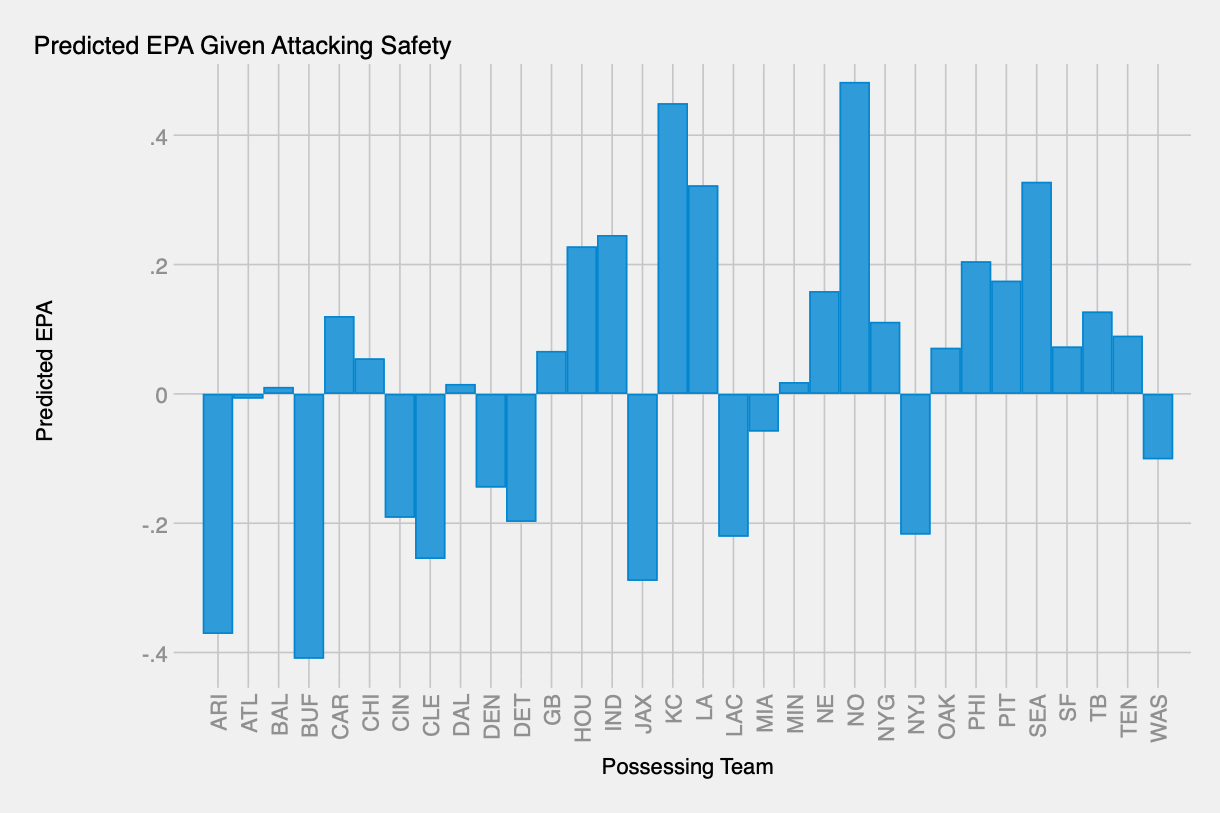

What's  most notable in the above graph is the wide swings we find across offensive opponents. Half the league is prepared to handle a safety attack and achieve a positive outcome, while the other half clearly is not - information we anticipate defensive coordinators would be pleased to get their hands on.  

**Conclusion**

We have demonstrated the developement and usefullnes of quantifying and evaluating the "safety attack" as a tool to defend against the pass. In addition to evaluating the Jamal Adams trade, we belive this measure will be useful in situational football defensive play calling, evaluating opponents and individual players, and projecting success of an indiviual player given their style of play and pairing that style with defensive play caller tendencies. 

Team DGA: 
Clark Demasi -clark@demasi-group.com
Cory Kays - corykays@gmail.com 